# GAN Project
## Liz Parker, Colin Craighead, and Aren Dalloul

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import utils
import tensorflow.keras.preprocessing.image as img
import scipy.io
from PIL import Image
import xml.etree.ElementTree as ET 

In [2]:
train_mat = scipy.io.loadmat("data/train_data.mat")

In [3]:
def unpack_mat(mat, train_or_test):
    df = pd.DataFrame()
    paths = []
    crops = []
    num_datapoints = len(mat[train_or_test][0][0][0])
    for i in range(num_datapoints):
        path = "images/" + mat[train_or_test][0][0][0][i][0][0]
        paths.append(path)
        ano_path = "Annotation/" + mat[train_or_test]['annotation_list'][0][0][i][0][0]
        tree = ET.parse(ano_path)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox') 
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            crop = (xmin, ymin, xmin+w, ymin+w)
        crops.append(crop)
    df['path'] = paths
    df['crops'] = crops
    return df

In [4]:
train_df = unpack_mat(train_mat, 'train_info')
train_df = train_df.sample(frac=.5)

In [5]:
train_df

,path,crops
10630,images/n02111889-Samoyed/n02111889_4353.jpg,"(116, 26, 392, 302)"
6049,images/n02100583-vizsla/n02100583_11231.jpg,"(146, 74, 403, 331)"
10640,images/n02111889-Samoyed/n02111889_5680.jpg,"(67, 2, 398, 333)"
4244,images/n02096294-Australian_terrier/n02096294_...,"(0, 1, 428, 429)"
3438,images/n02094114-Norfolk_terrier/n02094114_382...,"(20, 21, 291, 292)"
...,...,...
7171,images/n02104029-kuvasz/n02104029_4571.jpg,"(166, 168, 237, 239)"
2600,images/n02092002-Scottish_deerhound/n02092002_...,"(101, 57, 379, 335)"
9050,images/n02108000-EntleBucher/n02108000_1112.jpg,"(21, 10, 182, 171)"
10445,images/n02111277-Newfoundland/n02111277_3153.jpg,"(0, 23, 231, 254)"


In [6]:
# bad dog
train_df = train_df[train_df['path'] != 'images/n02105855-Shetland_sheepdog/n02105855_2933.jpg']

In [7]:
X_train = np.array([img.img_to_array(Image.open(row['path']).crop(row['crops']).resize((64,64))) for index, row in train_df.iterrows()])

In [8]:
# for index, row in train_df.iterrows():
#     s = img.img_to_array(Image.open(row['path']).crop(row['crops']).resize((64,64))).shape
#     if(s != (64,64,3)):
#         print("Bad index",index)
#         print(s)

In [9]:
# for index, row in train_df.iterrows():
#     if index == 7904:
#         print(row['path'])

In [10]:
X_train.shape

(5999, 64, 64, 3)

In [11]:
# puts pixels between -1, 1
def normalize_image(image):
    image = np.asarray(image, np.float32)
    return image / 127.5 - 1

In [12]:
# moves pixels back to (0, 1)
def denormalize_image(image):
    return ((image+1)*127.5).astype(np.uint8)

In [13]:
X_train = normalize_image(X_train)

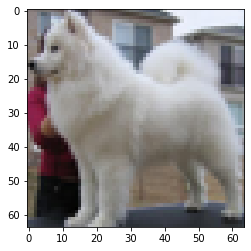

In [14]:
plt.imshow(denormalize_image(X_train[0]))

In [15]:
init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [16]:
def create_discriminator():
    discriminator = tf.keras.models.Sequential()

    discriminator.add(tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', input_shape=(64,64,3)))
    discriminator.add(tf.keras.layers.BatchNormalization())
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    
    discriminator.add(tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding='same'))
    discriminator.add(tf.keras.layers.BatchNormalization())
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    
    discriminator.add(tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    discriminator.add(tf.keras.layers.BatchNormalization())
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    
    discriminator.add(tf.keras.layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    discriminator.add(tf.keras.layers.BatchNormalization())
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    
    discriminator.add(tf.keras.layers.Conv2D(512, kernel_size=4, strides=2, padding='same'))
    discriminator.add(tf.keras.layers.BatchNormalization())
    discriminator.add(tf.keras.layers.LeakyReLU(0.2))
    
    discriminator.add(tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same'))

    discriminator.add(tf.keras.layers.Flatten())
    discriminator.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
    return discriminator


discriminator = create_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       1

In [17]:
INPUT_SIZE = 100
PLOT_FRECUENCY = 3

In [18]:
def create_generator():
    generator = tf.keras.models.Sequential()
    generator.add(tf.keras.layers.Dense(units=256*4*4,input_dim=INPUT_SIZE))
    generator.add(tf.keras.layers.Reshape((4,4,256)))

    generator.add(tf.keras.layers.Conv2DTranspose(1024, 5, strides=2, padding='same',kernel_initializer=init))
    generator.add(tf.keras.layers.BatchNormalization())
    generator.add(tf.keras.layers.LeakyReLU(0.2))
    
    generator.add(tf.keras.layers.Conv2DTranspose(512, 5, strides=2, padding='same',kernel_initializer=init))
    generator.add(tf.keras.layers.BatchNormalization())
    generator.add(tf.keras.layers.LeakyReLU(0.2))
    
    generator.add(tf.keras.layers.Conv2DTranspose(256, 5, strides=2, padding='same',kernel_initializer=init))
    generator.add(tf.keras.layers.BatchNormalization())
    generator.add(tf.keras.layers.LeakyReLU(0.2))

    generator.add(tf.keras.layers.Conv2DTranspose(128, 5, strides=2, padding='same',kernel_initializer=init))
    generator.add(tf.keras.layers.BatchNormalization())
    generator.add(tf.keras.layers.LeakyReLU(0.2))
    
    generator.add(tf.keras.layers.Conv2DTranspose(3, 5, strides=1, activation='tanh', padding='same',kernel_initializer=init))
    
    generator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

    return generator


generator = create_generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 1024)        6554624   
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 1024)        4096      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 512)       13107712  
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 512)      

In [19]:
def create_gan(generator, discriminator):
    discriminator.trainable = False

    gan_input = tf.keras.layers.Input(shape=(INPUT_SIZE,))
    generator_output = generator(gan_input)
    gan_output = discriminator(generator_output)

    gan = tf.keras.models.Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.5))

    return gan


gan = create_gan(generator, discriminator)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 3)         24189699  
_________________________________________________________________
sequential (Sequential)      (None, 1)                 2799314   
Total params: 26,989,013
Trainable params: 24,185,859
Non-trainable params: 2,803,154
_________________________________________________________________


In [20]:
def plot_images(generator, size=25, dim=(5,5), figsize=(10,10)):    
    noise= generate_noise(size)
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(denormalize_image(generated_images[i]), interpolation='nearest')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    
def plot_loss(epoch, g_losses, d_losses):
    plt.figure(figsize=(10,5))
    plt.title("Loss, Epochs 0-" + str(epoch))
    plt.plot(g_losses,label="Generator")
    plt.plot(d_losses,label="Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [21]:
def generate_noise(size):
    return np.random.randn(size,INPUT_SIZE)

In [22]:
# returns numbers between .7 and 1.2
# this will then be multipled by the label 1.0 to smooth it over
def label_smooth_factor(size):
    return np.random.rand(size)/2 + .7

In [23]:
# Switches Some images to the oposite group
def swap_group(prob_flip,size,real_images_batch,fake_images_batch):
    for i in range(size):
        flip = np.random.rand()
        if(flip<prob_flip):
            holder = real_images_batch[i]
            real_images_batch[i] = fake_images_batch[i]
            fake_images_batch[i] = holder
    return real_images_batch, fake_images_batch

In [24]:
def training(epochs=1, batch_size=32):
    #Loading Data
    batches = X_train.shape[0] / batch_size
    
    # Adversarial Labels
    y_valid = np.ones(batch_size)*label_smooth_factor(batch_size)
    y_fake = np.zeros(batch_size)
    discriminator_loss, generator_loss = [], []

    for epoch in range(1, epochs+1):
        g_loss = 0; d_loss = 0

        for _ in range(int(batches)):
            # Random Noise and Images Set
            noise = generate_noise(batch_size)
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

            # Generate Fake Images
            generated_images = generator.predict(noise)
            
            #random swaps
            image_batch, generated_images = swap_group(.05,batch_size,image_batch,generated_images)
            
            # Train Discriminator (Fake and Real)
            discriminator.trainable = True
            d_valid_loss = discriminator.train_on_batch(image_batch, y_valid)
            d_fake_loss = discriminator.train_on_batch(generated_images, y_fake)            

            d_loss += (d_fake_loss + d_valid_loss)/2
            
            # Train Generator
            noise = generate_noise(batch_size)
            discriminator.trainable = False
            g_loss += gan.train_on_batch(noise, y_valid)
            
        discriminator_loss.append(d_loss/batches)
        generator_loss.append(g_loss/batches)
            
        if epoch % PLOT_FRECUENCY == 0:
            print('Epoch', epoch)
            plot_images(generator)
            plot_loss(epoch, generator_loss, discriminator_loss)



Epoch 3


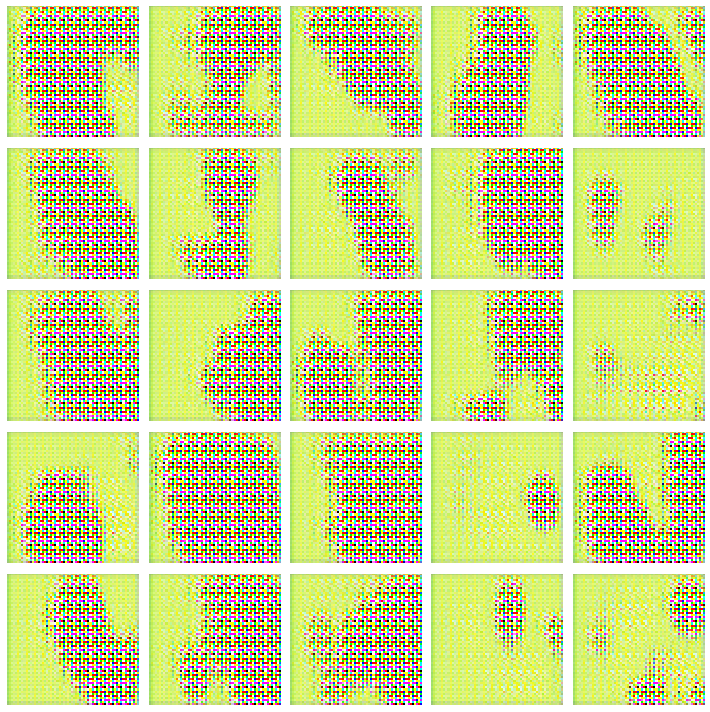

AttributeError: 'Line2D' object has no property 'colors'

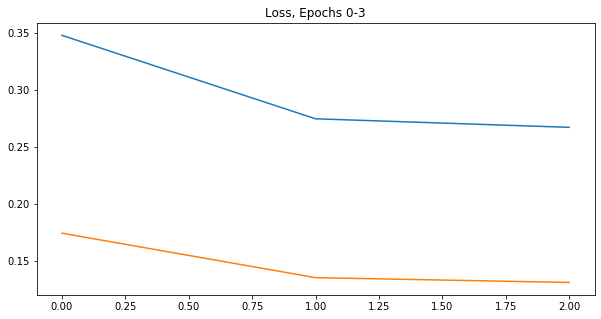

In [25]:
training(epochs=150)